In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Building ARIMA Models
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libraries for Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
%matplotlib inline

In [5]:
# load dataset
df_AMZN = pd.read_csv('./datasets/AMZN.csv', header=0, index_col=0)
df_AMZN.head()

,Open,High,Low,Close,Volume
Date,,,,,
6/11/2018,84.08,84.71,84.03,84.46,"2,335,484"
6/12/2018,84.65,84.98,84.58,84.94,"2,259,215"
6/13/2018,85.14,85.69,85.01,85.24,"3,327,529"
6/14/2018,85.67,86.24,85.44,86.19,"3,174,415"
6/15/2018,85.70,86.04,85.43,85.80,"4,777,646"


<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 6/11/2018 to 6/8/2023
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   float64
 4   Volume  1258 non-null   object 
dtypes: float64(4), object(1)
memory usage: 59.0+ KB


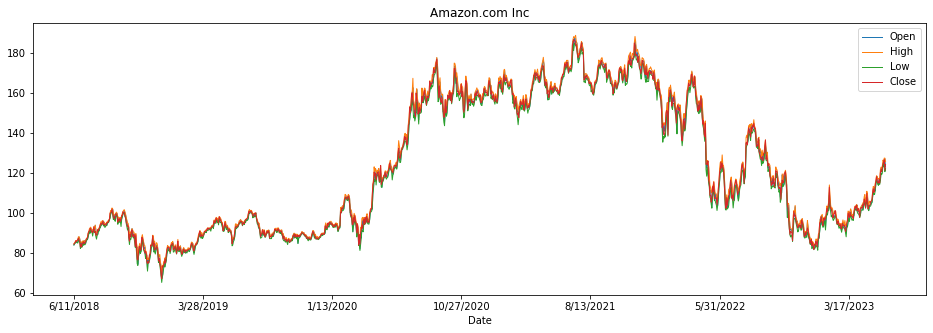

In [6]:
df_AMZN.info()
df_AMZN.plot(figsize=(16,5),lw=1, title="Amazon.com Inc")
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

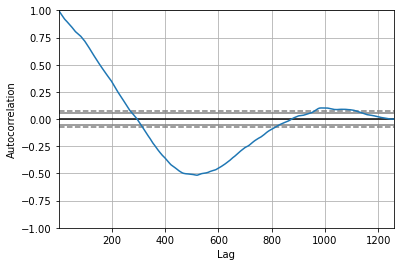

In [7]:
autocorrelation_plot(df_AMZN[["Open","High","Low","Close"]])

### Choosing Close Columns for model predictions

<class 'pandas.core.series.Series'>
Index: 1258 entries, 6/11/2018 to 6/8/2023
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7+ KB


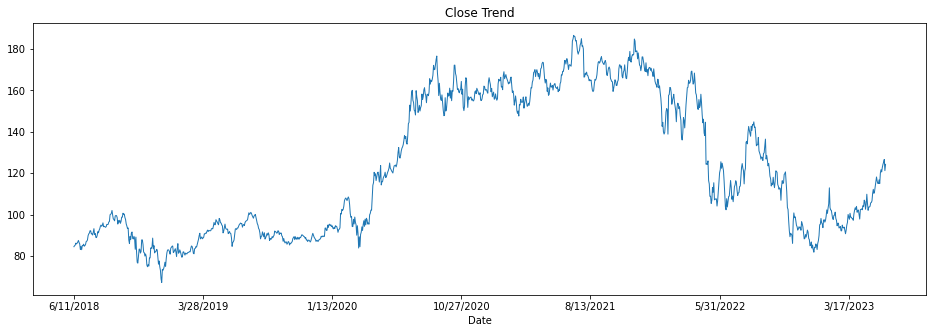

In [20]:
df_close = df_AMZN["Close"]
df_close.info()
df_close.plot(figsize=(16,5),lw=1, title="Close Trend")
plt.show()

### Split data for train and test

In [24]:
# Split the data for train and test
df_train = df_close[:1228].copy()
df_test = df_close[1228:].copy()

In [10]:
# Creating function to display ACF anf PACF plot
def plot_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
    # ACF
    plot_acf(df, ax=ax1, lags=30)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
    # PACF
    plot_pacf(df, ax=ax2, lags=20)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    # Lighten the borders
    ax1.spines['top'].set_alpha(.3); ax2.spines['top'].set_alpha(.3)
    ax1.spines['bottom'].set_alpha(.3); ax2.spines['bottom'].set_alpha(.3)
    ax1.spines['right'].set_alpha(.3); ax2.spines['right'].set_alpha(.3)
    ax1.spines['left'].set_alpha(.3); ax2.spines['left'].set_alpha(.3)

    ax1.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    plt.show()

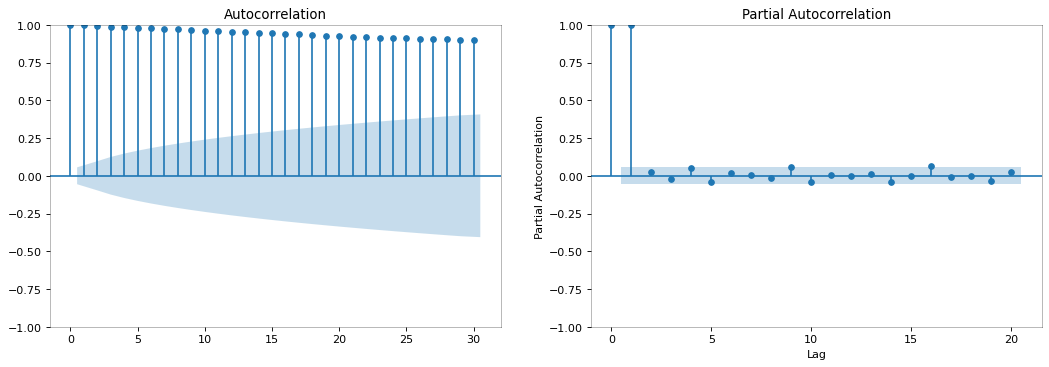

In [11]:
plot_correlation(df_train)

### Get p-value with ADF and KPSS test

In [12]:
#perform augmented Dickey-Fuller test to check if stationary
def ADF(df):
    result = adfuller(df)

    # Extract ADF Values
    print('Column Name: %s' % "Close Variable")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [13]:
ADF(df_train)

Column Name: Close Variable
ADF Statistic: -1.630885
p-value: 0.467028
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [14]:
# KPSS Test 
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [15]:
kpss_test(df_train.values)

Results of KPSS Test:
Test Statistic            2.320541
p-value                   0.010000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Transform to stationary

p.value: -1.990000000000009


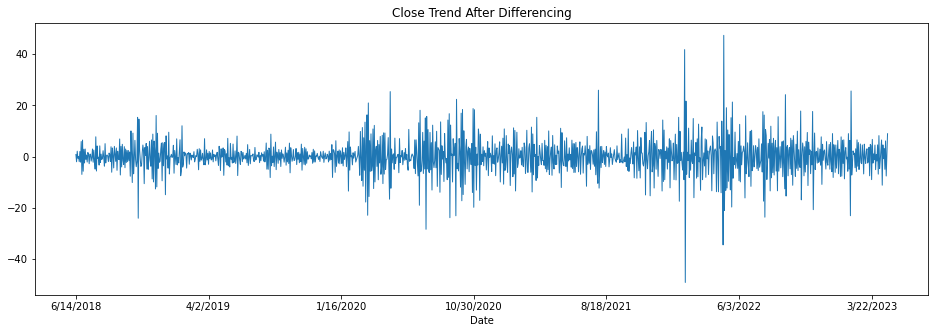

In [27]:
# Perform differencing
df_train_diff = df_train.diff().diff().diff().dropna()
df_train_diff.plot(figsize=(16,5), lw=1, title="Close Trend After Differencing")
print(f"p.value: {df_train_diff[1]}" )
plt.show()

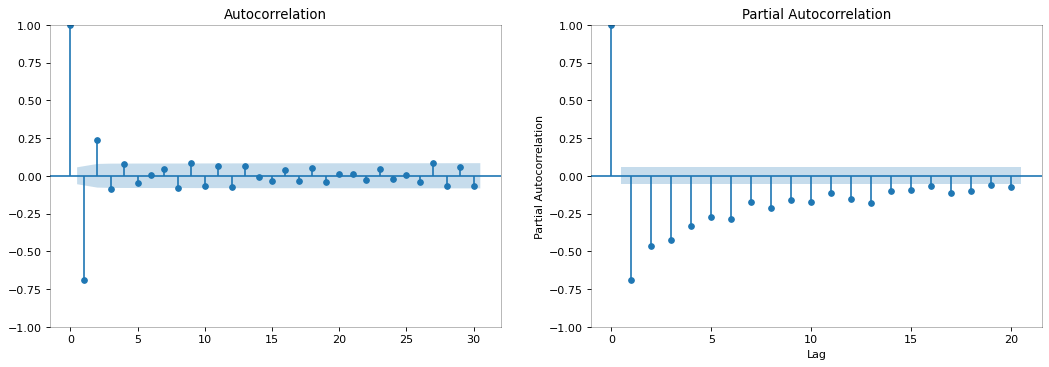

In [23]:
plot_correlation(df_train_diff)

## Determine model parameters p, q

In [28]:
# library that determine best parameters for ARIMA model
import pmdarima as pm
from pmdarima import auto_arima

In [29]:
model = auto_arima(df_train, start_p=0, start_q=0,
                          max_p=3, max_q=3,m=12,start_P=0,start_Q=0, 
                          max_P = 3, max_Q = 3,
                          seasonal=True,
                          d=3,D=3,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,3,0)[12]             : AIC=11230.832, Time=1.83 sec
 ARIMA(1,3,0)(1,3,0)[12]             : AIC=9008.646, Time=10.30 sec
 ARIMA(0,3,1)(0,3,1)[12]             : AIC=inf, Time=12.57 sec
 ARIMA(1,3,0)(0,3,0)[12]             : AIC=10349.992, Time=3.01 sec
 ARIMA(1,3,0)(2,3,0)[12]             : AIC=8827.747, Time=19.20 sec
 ARIMA(1,3,0)(3,3,0)[12]             : AIC=8782.035, Time=25.11 sec
 ARIMA(1,3,0)(3,3,1)[12]             : AIC=inf, Time=75.83 sec
 ARIMA(1,3,0)(2,3,1)[12]             : AIC=inf, Time=41.66 sec
 ARIMA(0,3,0)(3,3,0)[12]             : AIC=9587.521, Time=19.22 sec
 ARIMA(2,3,0)(3,3,0)[12]             : AIC=8520.913, Time=34.45 sec
 ARIMA(2,3,0)(2,3,0)[12]             : AIC=8569.467, Time=26.79 sec
 ARIMA(2,3,0)(3,3,1)[12]             : AIC=inf, Time=91.02 sec
 ARIMA(2,3,0)(2,3,1)[12]             : AIC=inf, Time=60.91 sec
 ARIMA(3,3,0)(3,3,0)[12]             : AIC=8282.829, Time=36.76 sec
 ARIMA(3,3,0)(2,3,0)[12]      

## Fit the ARIMA Model

In [30]:
model = ARIMA(df_train, order=(3,3,0))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1228
Model:                 ARIMA(3, 3, 0)   Log Likelihood               -3455.610
Date:                Fri, 16 Jun 2023   AIC                           6919.220
Time:                        11:42:12   BIC                           6939.663
Sample:                             0   HQIC                          6926.913
                               - 1228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2118      0.019    -64.750      0.000      -1.248      -1.175
ar.L2         -0.8958      0.028    -32.513      0.000      -0.950      -0.842
ar.L3         -0.4226      0.021    -20.092      0.0

## Make time series prediction

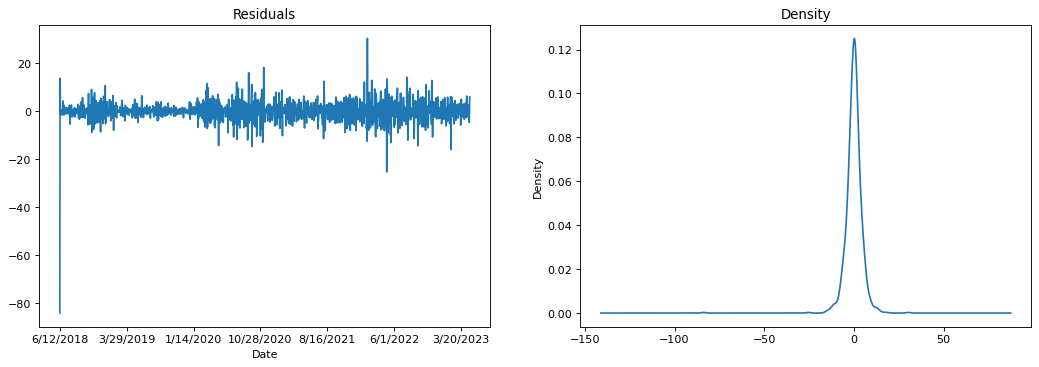

In [31]:
# Getting residuals pattern
# To make sure model capture adequate information from the data
residuals = model_fit.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(16,5), dpi=80)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

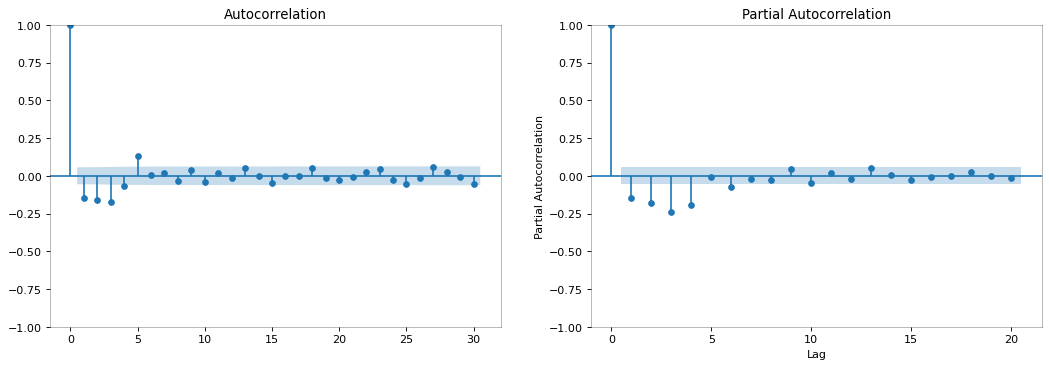

In [32]:
plot_correlation(residuals)

In [33]:
forecast = model_fit.forecast(len(df_test))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [34]:
forecast.index = df_test.index
new_df = pd.concat([forecast, df_test], axis=1)
new_df

,predicted_mean,Close
Date,,
4/27/2023,104.888585,109.82
4/28/2023,104.223222,105.45
5/1/2023,104.530048,102.05
5/2/2023,105.822921,103.63
5/3/2023,105.885515,103.65
5/4/2023,106.737672,104.00
5/5/2023,107.911234,105.66
5/8/2023,109.100873,105.83
5/9/2023,110.242315,106.62


<AxesSubplot:xlabel='Date'>

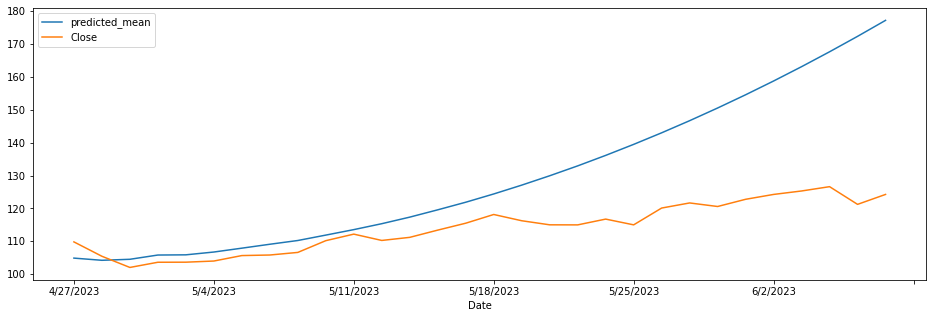

In [35]:
new_df.plot(figsize=(16,5))

## Fit the SARIMAX Model

In [36]:
train = df_close[:1228].copy()
test = df_close[1228:].copy()

In [37]:
final_model = SARIMAX(train,order=(3,3,0),seasonal_order=(3,3,0,12)) # Best model:  ARIMA(3,3,0)(3,3,0)[12]  
result = final_model.fit()
print(result.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06752D+00    |proj g|=  4.63246D-02


 This problem is unconstrained.



At iterate    5    f=  3.62307D+00    |proj g|=  3.25990D-01

At iterate   10    f=  3.36978D+00    |proj g|=  3.68988D-02

At iterate   15    f=  3.36679D+00    |proj g|=  1.08730D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     26      1     0     0   1.083D-06   3.367D+00
  F =   3.3667870863456000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1228
Model:             SARIMAX(3, 3, 0)x(3, 3, 0, 12)   Log

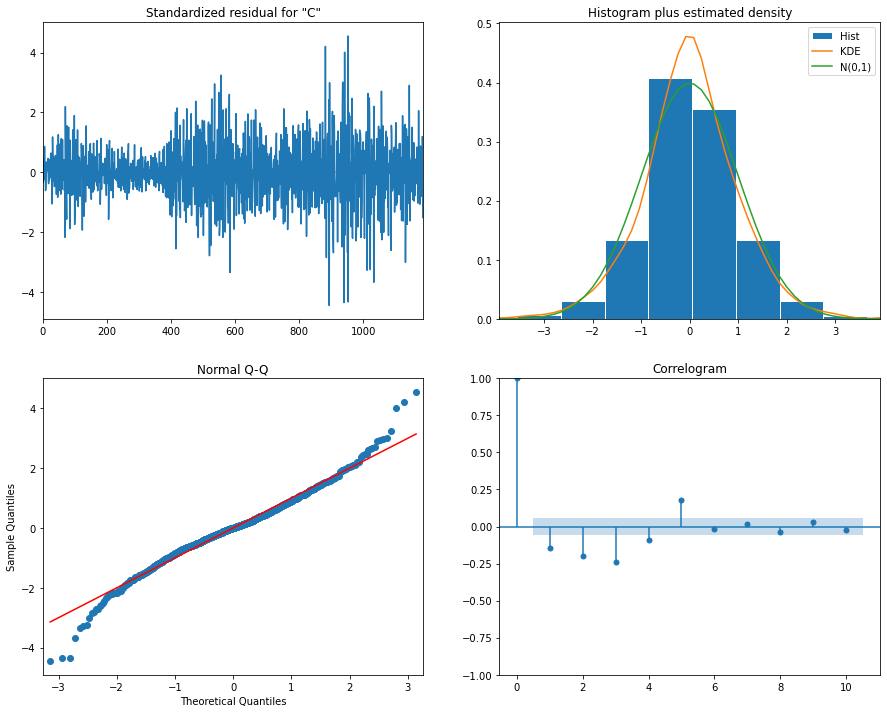

In [38]:
result.plot_diagnostics(figsize=(15, 12));

In [39]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# Best model:  ARIMA(0,1,1)(2,1,0)[12] 
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,1)(2,1,0,12) Predictions')# Plot predictions against known values

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [40]:
predictions.index = test.index
joined_df = pd.concat([predictions, test], axis=1)
joined_df

,"SARIMA(0,1,1)(2,1,0,12) Predictions",Close
Date,,
4/27/2023,108.973558,109.82
4/28/2023,110.898470,105.45
5/1/2023,119.938583,102.05
5/2/2023,133.039619,103.63
5/3/2023,142.565968,103.65
5/4/2023,151.026249,104.00
5/5/2023,165.819015,105.66
5/8/2023,177.145253,105.83
5/9/2023,190.437509,106.62


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Production')]

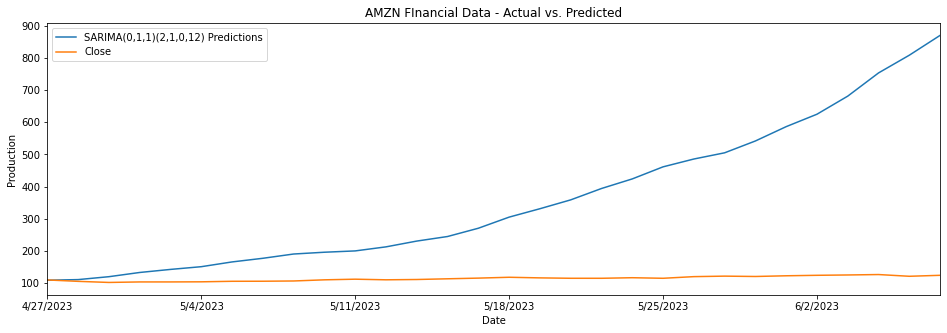

In [41]:
title = 'AMZN FInancial Data - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'
ax = joined_df.plot(legend=True, figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)